# Анализ данных сервиса аренды самокатов


# Описание проекта

Вы аналитик популярного сервиса аренды самокатов GoFast. Вам передали данные о некоторых пользователях из нескольких городов, а также об их поездках. Проанализируйте данные и проверьте некоторые гипотезы, которые могут помочь бизнесу вырасти.

Чтобы совершать поездки по городу, пользователи сервиса GoFast пользуются мобильным приложением. 

Сервисом можно пользоваться:

- без подписки
    - абонентская плата отсутствует;
    - стоимость одной минуты поездки — 8 рублей;
    - стоимость старта (начала поездки) — 50 рублей;
- с подпиской Ultra
    - абонентская плата — 199 рублей в месяц;
    - стоимость одной минуты поездки — 6 рублей;
    - стоимость старта — бесплатно.

Цель проекта - подготовка данных для проверки гипотиз, которые помогут развитию сервиса аренды самокатов.

Последовательность выполнения проекта:

- Обзор файлов с данными  
- Предобработка данных (обработка пропусков и дубликатов, изменение типов колонок).
- Анализ данных
- Объеденение данных
- Выделение данных по подпискам
- Подсчет выручки, выделение в отдельный столбец
- Проверка гипотез
- Выводы и рекомендации.

# Исходные данные.  

В основных данных, разбитых на три датасета, есть информация о пользователях, их поездках и подписках.



***Пользователи*** — users_go.csv

user_id — уникальный идентификатор пользователя  
name — имя пользователя  
age — возраст  
city — город  
subscription_type — тип подписки (free, ultra)  

***Поeздки*** — rides_go.csv

user_id — уникальный идентификатор пользователя  
distance — расстояние, которое пользователь проехал в текущей сессии (в метрах)  
duration — продолжительность сессии (в минутах) — время с того момента, как пользователь нажал кнопку «Начать поездку» до момента, как он нажал кнопку «Завершить поездку»  
date — дата совершения поездки  

***Подписки*** — subscriptions_go.csv

subscription_type — тип подписки
minute_price — стоимость одной минуты поездки по данной подписке  
start_ride_price — стоимость начала поездки  
subscription_fee — стоимость ежемесячного платежа  

#### Шаг 1. Загрузка данных

Для начала импортируем нужные библиотеки

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats as st
from scipy.stats import binom
from math import sqrt

In [2]:
# открываем и сохраняем файлы users_go.csv, rides_go.csv и subscriptions_go.csv в датафреймы из директории или по ссылке:
try:
    df_users = pd.read_csv('/datasets/users_go.csv')
    df_riders = pd.read_csv('/datasets/rides_go.csv')
    df_subs = pd.read_csv('/datasets/subscriptions_go.csv')
except:
    df_users = pd.read_csv('https://code.s3.yandex.net/datasets/users_go.csv')
    df_riders = pd.read_csv('https://code.s3.yandex.net/datasets/rides_go.csv')
    df_subs = pd.read_csv('https://code.s3.yandex.net/datasets/subscriptions_go.csv')

In [3]:
# Установим опцию по выводу всех колонок dataframe:
pd.set_option('display.max_columns', None)

***Датафрейм с пользователями***

In [4]:
#Посмотрим полную информацию датафрейма df_users:
df_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB


In [5]:
# выведем первые пять строк датафрейма df_users:
df_users.head()

,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra


В датасете df_users 5 столбцов и 1564 записей. Датасет содержит информацию о пользователе - его id, имени, возрасте, местоположении и виде подписки на сервис аренды. Столбцы датафрейма имеют тип object, int64 и float64. Пропусков нет.

***Датафрейм с поездками***

In [6]:
#Посмотрим полную информацию датафрейма df_riders:
df_riders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   18068 non-null  int64  
 1   distance  18068 non-null  float64
 2   duration  18068 non-null  float64
 3   date      18068 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 564.8+ KB


In [7]:
# выведем первые пять строк датафрейма df_riders:
df_riders.head()

,user_id,distance,duration,date
0,1,4409.919140,25.599769,2021-01-01
1,1,2617.592153,15.816871,2021-01-18
2,1,754.159807,6.232113,2021-04-20
3,1,2694.783254,18.511000,2021-08-11
4,1,4028.687306,26.265803,2021-08-28


В датасете df_riders 4 столбца и 18068 записей. Датасет содержит информацию о пользователе - его id, расстояние, которое пользователь проехал в текущей сессии (в метрах), продолжительность сессии (в минутах) и дату совершения поездки имени. Столбцы датафрейма имеют тип object, int64 и float64. Пропусков нет.

***Датафрейм с подпиской***

In [8]:
#Посмотрим полную информацию датафрейма df_subs:
df_subs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   subscription_type  2 non-null      object
 1   minute_price       2 non-null      int64 
 2   start_ride_price   2 non-null      int64 
 3   subscription_fee   2 non-null      int64 
dtypes: int64(3), object(1)
memory usage: 192.0+ bytes


In [9]:
# выведем первые пять строк датафрейма df_subs:
df_subs.head()

,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


В датасете df_subs 4 столбца и всего 2 записи с описанием подписки: тип подписки, стоимость одной минуты поездки по данной подписке, стоимость начала поездки и стоимость ежемесячного платежа. Столбцы датафрейма имеют тип object и int64. Пропусков нет.

#### Шаг 2. Предобработка данных

*Приведем столбец `date` из датафрейма `df_riders` к типу datetime.*

In [10]:
# Переведем значения в столбце date (дата совершения поездки) в формат даты:
df_riders['date'] = pd.to_datetime(df_riders['date'], format='%Y-%m-%d')

In [11]:
# Проверяем:
df_riders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   18068 non-null  int64         
 1   distance  18068 non-null  float64       
 2   duration  18068 non-null  float64       
 3   date      18068 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(2), int64(1)
memory usage: 564.8 KB


Проверим датафреймы на явные дубликаты

In [12]:
# датафрейм df_users:
df_users.duplicated().sum()

31

In [13]:
# скорее всего дубликаты содержатся в столбце user_id, проверяем:
df_users[df_users['user_id'].duplicated(keep=False)]

,user_id,name,age,city,subscription_type
15,16,Амалия,27,Краснодар,ultra
42,43,Стефания,22,Омск,ultra
46,47,Юрий,28,Тюмень,ultra
71,72,Никита,25,Москва,ultra
107,108,Влада,29,Тюмень,ultra
...,...,...,...,...,...
1560,829,Федор,29,Пятигорск,free
1561,809,Юрий,26,Сочи,free
1562,307,Ясмина,19,Краснодар,ultra
1563,47,Юрий,28,Тюмень,ultra


In [14]:
# удаляем дубликаты:
df_users.drop_duplicates(inplace=True)

In [15]:
# сразу проверим на не явные дубликаты:
df_users['city'].unique()

array(['Тюмень', 'Омск', 'Москва', 'Ростов-на-Дону', 'Краснодар',
       'Пятигорск', 'Екатеринбург', 'Сочи'], dtype=object)

In [16]:
df_users['name'].unique()

array(['Кира', 'Станислав', 'Алексей', 'Константин', 'Адель', 'Регина',
       'Игорь', 'Юрий', 'Ян', 'Валерий', 'Агата', 'Марк', 'Ева',
       'Антонина', 'Валерия', 'Амалия', 'Даниил', 'Аделина', 'Святогор',
       'Борис', 'Вероника', 'Ростислав', 'Назар', 'Эдуард', 'Василий',
       'Денис', 'Тамара', 'Николай', 'Эвелина', 'Федор', 'Руслан', 'Иван',
       'Любовь', 'Ярослава', 'Майя', 'Ильдар', 'Данила', 'Нина',
       'Стефания', 'Ясмина', 'Дмитрий', 'Александр', 'Одиссей', 'Арсений',
       'Алла', 'Таисия', 'Максим', 'Юлиана', 'Павел', 'Карина', 'Алиса',
       'Лидия', 'Рамиль', 'Родион', 'Ника', 'Оксана', 'Анастасия',
       'Маргарита', 'Вера', 'Тимур', 'Никита', 'Лев', 'Влад', 'Артур',
       'Анна', 'Ольга', 'Вячеслав', 'Ксения', 'Виталина', 'Владислав',
       'Тамерлан', 'Амина', 'Вадим', 'Олеся', 'Зарина', 'Егор', 'Гордей',
       'Лилия', 'Святослав', 'Роберт', 'Амир', 'Влада', 'Богдан',
       'Полина', 'Марат', 'Елисей', 'Макар', 'Алина', 'Глеб', 'Андрей',
       'Ал

In [17]:
df_users['subscription_type'].unique()

array(['ultra', 'free'], dtype=object)

In [18]:
# проверяем остались еще дубликаты:
df_users.duplicated().sum()

0

In [19]:
# датафрейм df_riders:
df_riders.duplicated().sum()

0

In [20]:
# датафрейм df_subs:
df_subs.duplicated().sum()

0

Создадим новый столбец с номером месяца на основе столбца `date` датасета `df_riders`

проверяем за какой период представлены данные, чтобы данные из разных годов не собрались по месяцам в один месяц

In [21]:
df_riders['date'].dt.year.unique()

array([2021])

Данные представлены всего за один год

In [22]:
# Добавляем в датасет столбец с номером месяца:
df_riders['month'] = df_riders['date'].dt.month

In [23]:
# Проверяем:
df_riders.head()

,user_id,distance,duration,date,month
0,1,4409.919140,25.599769,2021-01-01,1
1,1,2617.592153,15.816871,2021-01-18,1
2,1,754.159807,6.232113,2021-04-20,4
3,1,2694.783254,18.511000,2021-08-11,8
4,1,4028.687306,26.265803,2021-08-28,8


**Вывод:**

Удалили строки-дубликаты (дубликаты в столбце`user_id` датафрейма df_users). 
Добавили столбец month с номером месяца.
Пропущенных данных в датафремах нет.

#### Шаг 3. Исследовательский анализ данных

Опишите и визуализируйте общую информацию о пользователях и поездках:

##### частота встречаемости городов

In [24]:
# Подсчитаем кол-во пользователей по городам:
users_by_city = df_users['city'].value_counts()
users_by_city

Пятигорск         219
Екатеринбург      204
Ростов-на-Дону    198
Краснодар         193
Сочи              189
Омск              183
Тюмень            180
Москва            168
Name: city, dtype: int64

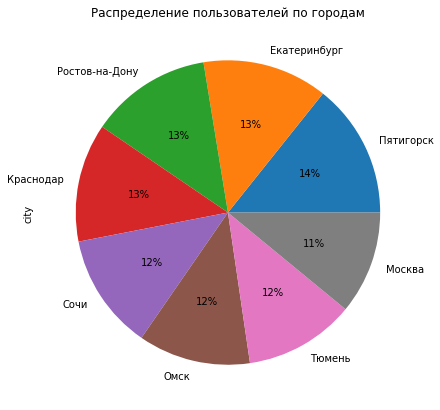

In [25]:
# Посмотрим график распределения кол-ва пользователей по городам:
users_by_city.plot(title='Распределение пользователей по городам',
                   kind='pie', 
                   y='users_by_city',
                   autopct = '%1.0f%%',
                   figsize=(7,7));

**Вывод:**

Наибольшее кол-во пользователей в Пятигорске - 219, Наименьшее в Москве -168.

<div class="alert-info" style="padding: 20px; border-radius: 10px">
<b>Комментарий студента 💎</b>

Единственный плюс в данном случае - данные на круговой диаграмме подчеркивают свою равномерность. Потому и решил строить ее, а не столбчатую.</div>

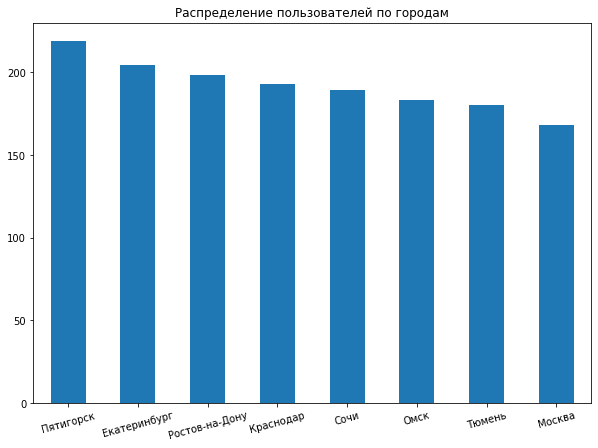

In [26]:
# Посмотрим график распределения кол-ва пользователей по городам:
users_by_city.plot(title='Распределение пользователей по городам',
                   kind='bar', 
                   y='users_by_city', 
                   figsize=(10,7))
plt.xticks(rotation = 15);

##### Соотношение пользователей с подпиской и без подписки

In [27]:
# Подсчитаем кол-во пользователей с подпиской и без:
sub_count = df_users['subscription_type'].value_counts()
sub_count

free     835
ultra    699
Name: subscription_type, dtype: int64

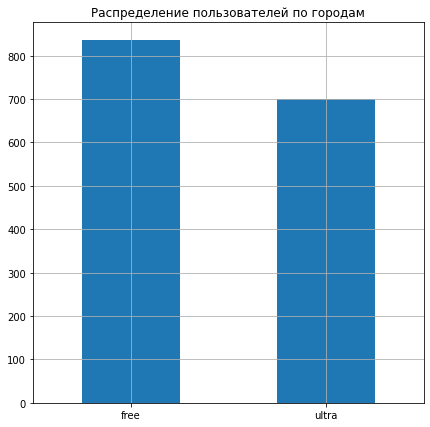

In [28]:
# Посмотрим график распределения кол-ва пользователей по подписке:
sub_count.plot(title='Распределение пользователей по городам', 
               kind='bar',
               y='users_by_city',
               figsize=(7,7), 
               grid=True)
plt.xticks(rotation = 0);

**Вывод:**

Кол-во пользователей без подписки - 835, пользователей с подпиской - 699. Пользователей без подписки больше, но всего процентов на 20, а значит у компании-прокатчика есть неплохая база постоянных клиентов

##### Возраст пользователей

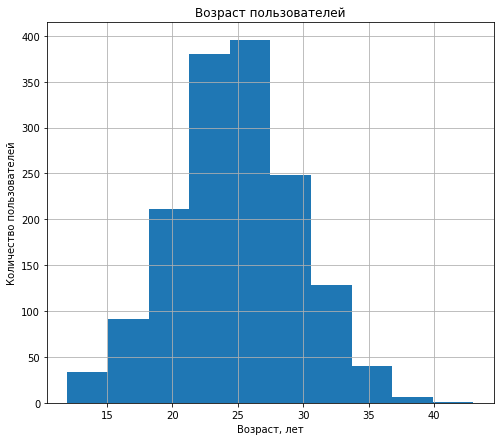

In [29]:
# Посторим гистограмму распределения пользователей по возрасту:
df_users.hist(['age'], figsize=(8, 7))
plt.title('Возраст пользователей')
plt.xlabel('Возраст, лет')
plt.ylabel('Количество пользователей');

In [30]:
# Посмотрим на наименьший возраст пользователей сервисом:
df_users['age'].sort_values().head(10)

664     12
66      12
727     12
34      12
235     13
1249    13
314     13
83      13
553     13
1241    13
Name: age, dtype: int64

In [31]:
# Посмотрим на наибольший возраст пользователей сервисом:
df_users['age'].sort_values(ascending=False).head(10)

1201    43
961     39
804     38
453     38
383     38
205     37
848     37
721     36
1491    36
644     36
Name: age, dtype: int64

In [32]:
df_users.describe()

,user_id,age
count,1534.000000,1534.000000
mean,767.500000,24.903520
std,442.971971,4.572367
min,1.000000,12.000000
25%,384.250000,22.000000
50%,767.500000,25.000000
75%,1150.750000,28.000000
max,1534.000000,43.000000


**Вывод:**

Самыми младшими являются пользователи от 12 до 13 лет.
Самыми старшими - от 36 до 43 лет.
Основная часть пользователей возрастом от 22 до 28 лет. Медиана: 25 лет. Все что меньше 15 лет и больше 40 можно считать редкими значениями.

##### Расстояние, которое пользователь преодолел за одну поездку

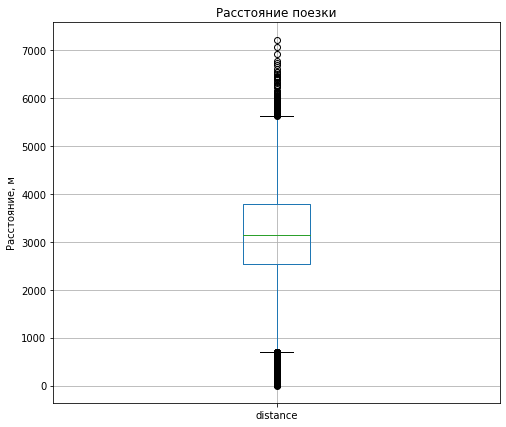

In [33]:
# Построим диаграмму размаха расстояния, которое пользователь преодолел за одну поездку:
df_riders.boxplot(column='distance', figsize=(8, 7))
plt.title('Раcстояние поезки')
plt.ylabel('Расстояние, м');

In [34]:
# Посмотрим на самые короткие поездки по протяженности (в метрах) пользователей сервисом:
df_riders['distance'].sort_values().head(10)

11555     0.855683
9541      2.570787
13690     4.329506
8658      6.784447
7841      7.097072
8906     11.283615
8324     12.233115
13940    15.000606
15626    15.366168
11862    15.630873
Name: distance, dtype: float64

In [35]:
# Посмотрим на самые длинные поездки пользователейпо протяженности (в метрах) пользователей сервисом:
df_riders['distance'].sort_values(ascending=False).head(10)

16309    7211.007745
16484    7066.003772
15580    6908.491343
17171    6760.940067
17242    6724.932981
10341    6671.969833
11385    6601.197575
12086    6538.937375
10915    6535.386520
11319    6503.600402
Name: distance, dtype: float64

**Вывод:** 
Самая короткая дистанция - 0.86 метра, самая длинная - 7.2 км
В основном пользователи проезжают от 2.5 км примерно до 4 км.

##### Продолжительность поездок

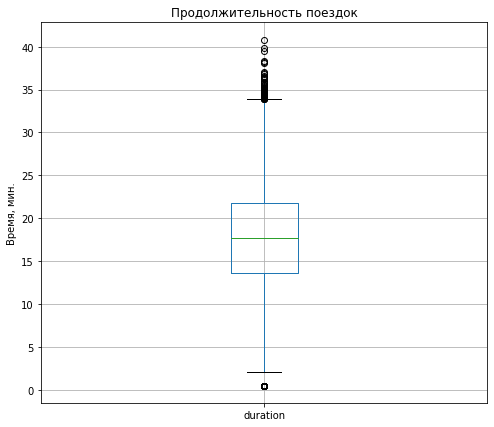

In [36]:
# Построим диаграмму размаха продолжительности поездок пользователей:
df_riders.boxplot(column='duration', figsize=(8, 7))
plt.title('Продолжительность поездок')
plt.ylabel('Время, мин.');

In [37]:
# Посмотрим на самые короткие поездки по времени (в минутах) пользователей сервисом:
df_riders['duration'].sort_values().head(10)

12013    0.5
17314    0.5
15029    0.5
7437     0.5
12967    0.5
15015    0.5
13012    0.5
7508     0.5
16589    0.5
9049     0.5
Name: duration, dtype: float64

In [38]:
# Посмотрим на самые длинные поездки по времени (в минутах) пользователей сервисом:
df_riders['duration'].sort_values(ascending=False).head(10)

4215    40.823963
4709    39.873856
2623    39.526602
1998    38.352763
6453    38.265229
143     38.125729
3729    37.014141
499     36.906491
6348    36.809310
4653    36.622595
Name: duration, dtype: float64

**Вывод:** 
Самая короткая по времени поездка - 0.5 минуты, самая длинная - 41 минута
В основном пользователи тратят на поездку от 13 до 22 минут.

***Итоговый вывод***

*Частота встречаемости городов:* наибольшее кол-во пользователей в Пятигорске - 219, Наименьшее в Москве -168, по-видимому из-за того, что Пятигорск по площади в разы меньше Москвы - в этом городе удобнее пользоваться сервисом для покрытия расстояния. Кол-во пользователей представленных в выборке примерно одинаковое.  

*Соотношение пользователей с подпиской и без подписки:* кол-во пользователей без подписки - 835 (~ 54%), пользователей с подпиской - 699 (~46%)  

*Возраст пользователей:* самыми младшими являются пользователи от 12 до 13 лет. Самыми старшими - от 36 до 43 лет.Наибольшее кол-во пользователей сервиса от 20 до 30 лет.  

*Расстояние, которое пользователь преодолел за одну поездку:* cамая короткая дистанция - 0.86 метра, самая длинная - 7.2 км. Короткая дистанция может быть связана с технической неисправностью самоката, его разряженности или же пользователь просто "передумал". В основном пользователи проезжают от 2.5 км примерно до 4 км.  

*Продолжительность поездок:* cамая короткая по времени поездка - 0.5 минуты, самая длинная - 41 минута. Так же как и в случае с пройденной дистанцией можно объяснить маленькую продолжительность поезки(тех. неисправность или же пользователь решил отказаться от поезки) В основном пользователи тратят на поездку от 13 до 22 минут.


#### Шаг 4. Объединение данных

##### Объединим данные о пользователях, поездках и подписках в один датафрейм

Посмотрим информацию о датафремах еще раз:

In [39]:
# Датафрем о пользователях:
df_users.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1534 entries, 0 to 1533
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1534 non-null   int64 
 1   name               1534 non-null   object
 2   age                1534 non-null   int64 
 3   city               1534 non-null   object
 4   subscription_type  1534 non-null   object
dtypes: int64(2), object(3)
memory usage: 71.9+ KB


In [40]:
# Датафрем о поездках:
df_riders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   18068 non-null  int64         
 1   distance  18068 non-null  float64       
 2   duration  18068 non-null  float64       
 3   date      18068 non-null  datetime64[ns]
 4   month     18068 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(2)
memory usage: 705.9 KB


In [41]:
# Датафрем о подписках:
df_subs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   subscription_type  2 non-null      object
 1   minute_price       2 non-null      int64 
 2   start_ride_price   2 non-null      int64 
 3   subscription_fee   2 non-null      int64 
dtypes: int64(3), object(1)
memory usage: 192.0+ bytes


In [42]:
# объеденим датафреймы df_users и df_riders в один по столбцу user_id:
df = df_users.merge(df_riders, on='user_id', how='left')

In [43]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18068 entries, 0 to 18067
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   user_id            18068 non-null  int64         
 1   name               18068 non-null  object        
 2   age                18068 non-null  int64         
 3   city               18068 non-null  object        
 4   subscription_type  18068 non-null  object        
 5   distance           18068 non-null  float64       
 6   duration           18068 non-null  float64       
 7   date               18068 non-null  datetime64[ns]
 8   month              18068 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(3), object(3)
memory usage: 1.4+ MB


In [44]:
# объеденим датафреймы df и df_subs в один по столбцу subscription_type:
df = df.merge(df_subs, on='subscription_type', how='left')

In [45]:
# посмотрим на полученный после всех объеденений датафрейм:
df

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,ultra,4409.919140,25.599769,2021-01-01,1,6,0,199
1,1,Кира,22,Тюмень,ultra,2617.592153,15.816871,2021-01-18,1,6,0,199
2,1,Кира,22,Тюмень,ultra,754.159807,6.232113,2021-04-20,4,6,0,199
3,1,Кира,22,Тюмень,ultra,2694.783254,18.511000,2021-08-11,8,6,0,199
4,1,Кира,22,Тюмень,ultra,4028.687306,26.265803,2021-08-28,8,6,0,199
...,...,...,...,...,...,...,...,...,...,...,...,...
18063,1534,Альберт,25,Краснодар,free,3781.098080,19.822962,2021-11-04,11,8,50,0
18064,1534,Альберт,25,Краснодар,free,2840.423057,21.409799,2021-11-16,11,8,50,0
18065,1534,Альберт,25,Краснодар,free,3826.185507,18.435051,2021-11-18,11,8,50,0
18066,1534,Альберт,25,Краснодар,free,2902.308661,16.674362,2021-11-27,11,8,50,0


In [46]:
# Посмотрим полную информацию объединенного датафрейма:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18068 entries, 0 to 18067
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   user_id            18068 non-null  int64         
 1   name               18068 non-null  object        
 2   age                18068 non-null  int64         
 3   city               18068 non-null  object        
 4   subscription_type  18068 non-null  object        
 5   distance           18068 non-null  float64       
 6   duration           18068 non-null  float64       
 7   date               18068 non-null  datetime64[ns]
 8   month              18068 non-null  int64         
 9   minute_price       18068 non-null  int64         
 10  start_ride_price   18068 non-null  int64         
 11  subscription_fee   18068 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(6), object(3)
memory usage: 1.8+ MB


***Вывод***  
Объединили все данные в одну таблицу, добавив информацию о подписках и поездках. Полученный датафрем `df` содержит 12 столбца и 18068 записей. Пропусков нет.

##### Создадим датафрейм с данными о пользователях без подписки

In [47]:
sub_free = df.query("`subscription_type` == 'free'")
sub_free

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
6500,700,Айдар,22,Омск,free,2515.690719,14.944286,2021-01-02,1,8,50,0
6501,700,Айдар,22,Омск,free,846.932642,16.234663,2021-02-01,2,8,50,0
6502,700,Айдар,22,Омск,free,4004.434142,20.016628,2021-02-04,2,8,50,0
6503,700,Айдар,22,Омск,free,1205.911290,9.782872,2021-02-10,2,8,50,0
6504,700,Айдар,22,Омск,free,3047.379435,17.427673,2021-02-14,2,8,50,0
...,...,...,...,...,...,...,...,...,...,...,...,...
18063,1534,Альберт,25,Краснодар,free,3781.098080,19.822962,2021-11-04,11,8,50,0
18064,1534,Альберт,25,Краснодар,free,2840.423057,21.409799,2021-11-16,11,8,50,0
18065,1534,Альберт,25,Краснодар,free,3826.185507,18.435051,2021-11-18,11,8,50,0
18066,1534,Альберт,25,Краснодар,free,2902.308661,16.674362,2021-11-27,11,8,50,0


**Визуализируем информацию о расстоянии поездки для пользователей без подписки**

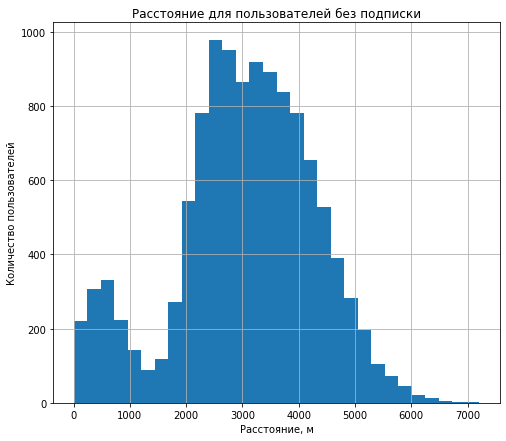

In [48]:
sub_free.hist(['distance'], bins= 30, figsize=(8,7))
plt.title('Расстояние для пользователей без подписки')
plt.xlabel('Расстояние, м')
plt.ylabel('Количество пользователей');

Пользователи без подписки проезжают от 2 до 5 км, есть пользователи, которые проехали свыше 6 км. Пик кол-ва пользователей приходится на расстояние в 2,5 км

**Визуализируем информацию о продолжительности времени поездки для пользователей без подписки**

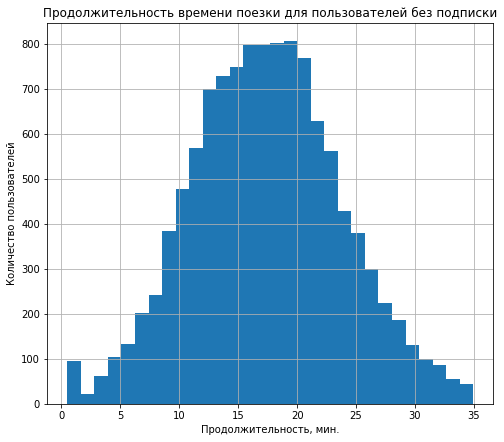

In [49]:
sub_free.hist(['duration'], bins= 30, figsize=(8,7))
plt.title('Продолжительность времени поезки для пользователей без подписки')
plt.xlabel('Продолжительность, мин.')
plt.ylabel('Количество пользователей');

Для пользователей без подписки время поездки составляет от 5 до 30 минут.

##### Создадим датафрейм с данными о пользователях с подпиской

In [50]:
sub_ultra = df.query("`subscription_type` == 'ultra'")
sub_ultra

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,ultra,4409.919140,25.599769,2021-01-01,1,6,0,199
1,1,Кира,22,Тюмень,ultra,2617.592153,15.816871,2021-01-18,1,6,0,199
2,1,Кира,22,Тюмень,ultra,754.159807,6.232113,2021-04-20,4,6,0,199
3,1,Кира,22,Тюмень,ultra,2694.783254,18.511000,2021-08-11,8,6,0,199
4,1,Кира,22,Тюмень,ultra,4028.687306,26.265803,2021-08-28,8,6,0,199
...,...,...,...,...,...,...,...,...,...,...,...,...
6495,699,Оксана,22,Москва,ultra,3973.046497,24.671163,2021-08-29,8,6,0,199
6496,699,Оксана,22,Москва,ultra,3288.702563,15.892886,2021-09-12,9,6,0,199
6497,699,Оксана,22,Москва,ultra,3076.159348,14.389525,2021-09-26,9,6,0,199
6498,699,Оксана,22,Москва,ultra,4707.845501,15.839579,2021-10-17,10,6,0,199


**Визуализируем информацию о расстоянии поездки для пользователей с подпиской**

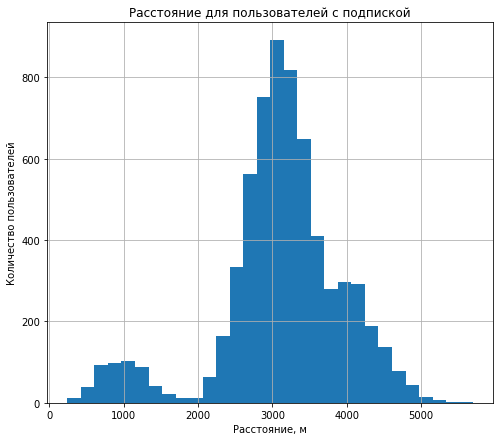

In [51]:
sub_ultra.hist(['distance'], bins= 30, figsize=(8,7))
plt.title('Расстояние для пользователей с подпиской')
plt.xlabel('Расстояние, м')
plt.ylabel('Количество пользователей');

**Визуализируем информацию о продолжительности времени поездки для пользователей с подпиской**

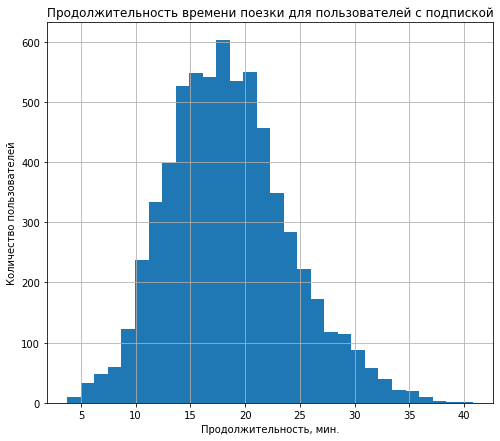

In [52]:
sub_ultra.hist(['duration'], bins= 30, figsize=(8,7))
plt.title('Продолжительность времени поезки для пользователей с подпиской')
plt.xlabel('Продолжительность, мин.')
plt.ylabel('Количество пользователей');

***Вывод***  

Объединили данные о пользователях, поездках и тарифах в один датафрейм.

Выделили два датафрейма - sub_free и sub_ultra (датасет для пользователей без подписки и датасет для пользоваетелей с подпиской)

Визуализировали информацию о расстоянии и времени для пользователей с подпиской и без:

Для пользователей без подписки время поездки составляет от 5 до 30 минут, и проезжают от 2 до 5 км, есть пользователи, которые проехали свыше 6 км. Пик кол-ва пользователей приходится на расстояние в 2,5 км

Для пользователей без подписки - в основном время укладывается в промежуток от 10 до 29 минут. Пик кол-ва пользователей приходится на расстояние в 3 км.

Так же в обеих группах замечен всплеск в районе 1000 метров и продолжительностью 5-10 мин, скорее всего это "интерес" пользователей к новому сервису аренды.

У пользователей без подписки значительно больше коротких поездок - до 1 км и в целом максимальная дальность поездки выше, чем у платных пользователей.

Таким образом, можно сделать вывод, что пользователи без подписки проезжают большее расстояние, чем пользователи на платном тарифе. При этом и те и другие пользователи укладываются в интервал до 30 минут.

Выборка пользователей без подписки почти в два раза превышает выборку пользователей с подпиской (11568 на 6500).

#### Шаг 5. Подсчёт выручки

##### Создадим датафрейм с агрегированными данными о поездках на основе датафрейма с объединёнными данными. Найдем суммарное расстояние, количество поездок и суммарное время для каждого пользователя за каждый месяц

In [53]:
# Создадим сводную таблицу:
df_pivot = df.pivot_table(index=['month', 'user_id'],
                          values = ['distance', 'duration', 'name', 'subscription_type'],
                          aggfunc = {'distance': 'sum',
                                     'duration' : 'sum',
                                     'name' : len,
                                     'subscription_type' : 'min'})

In [54]:
df_pivot.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 11331 entries, (1, 1) to (12, 1534)
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   distance           11331 non-null  float64
 1   duration           11331 non-null  float64
 2   name               11331 non-null  int64  
 3   subscription_type  11331 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 399.5+ KB


пропусков нет.

In [55]:
#Переименновываем столбцы:
df_pivot.columns = ['distance', 'duration','trips', 'subscription_type']

In [56]:
# каждое значение из столбца duration округляется с помощью «потолка»:
df_pivot['duration'] = np.ceil(df_pivot['duration'])

In [57]:
# Посмотрим на сводную таблицу, отсортированную по месяцу:
df_pivot.sort_values(by='month')

distance  duration  trips subscription_type
month user_id                                                 
1     1         7027.511294      42.0      2             ultra
      1061     12637.249630      42.0      3              free
      1063      3276.362299      10.0      1              free
      1064      5297.324649      15.0      1              free
      1065     14547.099333      97.0      4              free
...                     ...       ...    ...               ...
12    618       5269.450142      32.0      2             ultra
      619       2955.251037      17.0      1             ultra
      620       3972.842520      14.0      1             ultra
      600       3698.618505      14.0      1             ultra
      1534      2371.711192      16.0      1              free

[11331 rows x 4 columns]

In [58]:
# Посмотрим на произвольно выбранного пользователя:
df_pivot.query('user_id == 1000')

,,distance,duration,trips,subscription_type
month,user_id,,,,
1,1000,8896.242665,58.0,2,free
2,1000,8563.372738,53.0,2,free
3,1000,8125.115681,49.0,3,free
4,1000,6209.113980,28.0,2,free
6,1000,7347.037513,49.0,2,free
7,1000,2093.948848,12.0,1,free
8,1000,652.585149,7.0,1,free
10,1000,4887.494194,31.0,2,free
11,1000,5387.122991,26.0,2,free


##### Добавим столбец с помесячной выручкой, которую принёс каждый пользователь.

In [59]:
# Функция для помесячной выручке каждого пользователя:
def revenue(row):
    if row['subscription_type'] == 'free':
        return (df_subs['start_ride_price'][0] * row['trips'] +
        df_subs['minute_price'][0] * row['duration'] + df_subs['subscription_fee'][0])
    elif row['subscription_type'] == 'ultra':
        return (df_subs['start_ride_price'][1] * row['trips'] +
        df_subs['minute_price'][1] * row['duration'] + df_subs['subscription_fee'][1])
    else:
        return 'Not such sub'

In [60]:
# Добавим столбец с помесячной выручкой:
df_pivot['revenue_per_month'] = df_pivot.apply(revenue, axis=1)

In [61]:
# Проверяем:
df_pivot

distance  duration  trips subscription_type  \
month user_id                                                   
1     1        7027.511294      42.0      2             ultra   
      3        3061.777147      13.0      1             ultra   
      5        3914.646990      13.0      1             ultra   
      7        6478.080979      28.0      2             ultra   
      12       3577.151148      33.0      1             ultra   
...                    ...       ...    ...               ...   
12    1525     4597.854350      34.0      1              free   
      1526     3644.121544      23.0      1              free   
      1528     3998.569324      11.0      1              free   
      1532     6111.889853      41.0      2              free   
      1534     2371.711192      16.0      1              free   

               revenue_per_month  
month user_id                     
1     1                    451.0  
      3                    277.0  
      5                    277.0  
      7                    367.0  
      12                   397.0  
...                          ...  
12    1525                 322.0  
      1526                 234.0  
      1528                 138.0  
      1532                 428.0  
      1534                 178.0  

[11331 rows x 5 columns]

In [62]:
# Посмотрим на произвольно выбранного пользователя:
df_pivot.query('user_id == 1000')

,,distance,duration,trips,subscription_type,revenue_per_month
month,user_id,,,,,
1,1000,8896.242665,58.0,2,free,564.0
2,1000,8563.372738,53.0,2,free,524.0
3,1000,8125.115681,49.0,3,free,542.0
4,1000,6209.113980,28.0,2,free,324.0
6,1000,7347.037513,49.0,2,free,492.0
7,1000,2093.948848,12.0,1,free,146.0
8,1000,652.585149,7.0,1,free,106.0
10,1000,4887.494194,31.0,2,free,348.0
11,1000,5387.122991,26.0,2,free,308.0


***Вывод***  

Нашли суммарное расстояние, количество поездок и суммарное время для каждого пользователя за каждый месяц.  

Для каждого пользователя добавили столбец с помесячной выручкой.

#### Шаг 6. Проверка гипотез

##### Важно понять, тратят ли пользователи с подпиской больше времени на поездки? 

Если да, то пользователи с подпиской могут быть «выгоднее» для компании. Проверьте гипотезу. Используйте исходные данные о продолжительности каждой сессии — отдельно для подписчиков и тех, у кого нет подписки.

Гипотеза: пользователи с подпиской тратят больше времени на поездки, чем пользователи без подписки.
    
Сформулируем нулевую гипотезу:  
H_0: Продолжительность поездки ('duration') пользователей с подпиской (ultra) = продолжительность поездки (duration) пользователей без подписки (free).

Сформулируем альтернативную гипотезу:  
H_1: Продолжительность поездки ('duration') пользователей с подпиской (ultra) > продолжительность поездки (duration) пользователей без подписки (free).

Уровень статистичиской значимости примем:  
alpha = 0.05

In [63]:
# Продолжительность поездки без подписки:
free_dur = sub_free['duration']

# Продолжительность поездки c подпиской:
ultra_dur = sub_ultra['duration'] 

# Уровень значимости:
alpha = 0.05

# Проводим ttest для двух выборок, 
# в качестве альтернативной используем одностороннюю гипотизу "больше":
results = st.ttest_ind(ultra_dur, 
                       free_dur,
                       equal_var = False, # выборки разного размера 
                       alternative = 'greater')



print(results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не удалось отвергнуть нулевую гипотезу')

5.6757813771289775e-37
Отвергаем нулевую гипотезу


***Вывод***  

Полученное значение p-value меньше заданного уровня значимости, поэтому можно отвергнуть нулевую гипотезу. Есть основание говорить, что пользователи с подпиской (ultra) тратят больше времени на поездки, чем пользователи без подписки.

##### Расстояние одной поездки в 3130 метров — оптимальное с точки зрения износа самоката. Можно ли сказать, что расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров? Проверьте гипотезу и сделайте выводы.

Гипотеза: пользователи с подпиской проезжают расстояние, не превышающее 3130 метров за одну поездку.

Сформулируем нулевую гипотезу:  
H_0: Расстояние (distance) поездки пользователей с подпиской (ultra) = 3130 метрам.

Сформулируем альтернативную гипотезу:  
H_1: Расстояние (distance) поездки пользователей с подпиской (ultra) <  3130 метра.

Уровень статистичиской значимости примем:  
alpha = 0.05

In [64]:
# Расстояние поездки c подпиской:
ultra_dist = sub_ultra['distance']

# Оптимальное расстояние:
distance = 3130.0

# Уровень значимости:
alpha = 0.05

# Проводим ttest для одной выборки, в качестве альтернативной используем одностороннюю гипотизу "меньше":
results = st.ttest_1samp(
    ultra_dist, 
    distance,
    alternative='less')
    
print(results.pvalue)

if (results.pvalue < alpha):
    print('Отвергаем нулевую гипотезу')
else:
    print('Не удалось отвергнуть нулевую гипотезу')

0.08046311521502146
Не удалось отвергнуть нулевую гипотезу


***Вывод***  

Полученное значение p-value больше заданного уровня значимости, не удалось отвергнуть нулевую гипотезу. Нет оснований утверждать, что пользователи с подпиской проезжают расстояние, не превышающее 3130 метров.

In [65]:
# Расстояние поездки c подпиской:
ultra_dist = sub_ultra['distance']

# Оптимальное расстояние:
distance = 3130.0

# Уровень значимости:
alpha = 0.05

# Проводим ttest для одной выборки, в качестве альтернативной используем одностороннюю гипотизу "меньше":
results = st.ttest_1samp(
    ultra_dist, 
    distance,
    alternative='greater')
    
print(results.pvalue)

if (results.pvalue < alpha):
    print('Отвергаем нулевую гипотезу')
else:
    print('Не удалось отвергнуть нулевую гипотезу')

0.9195368847849785
Не удалось отвергнуть нулевую гипотезу


##### Проверьте гипотезу о том, будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки.

Гипотеза: помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки.

Сформулируем нулевую гипотезу:  
H_0: Помесячная выручка ('revenue_per_month') пользователей с подпиской (ultra) = помесячная выручка ('revenue_per_month') пользователей без подписки (free).

Сформулируем альтернативную гипотезу:  
H_1: Помесячная выручка ('revenue_per_month') пользователей с подпиской (ultra) > помесячная выручка ('revenue_per_month') пользователей без подписки (free).  

Уровень статистичиской значимости примем:  
alpha = 0.05

In [66]:
# Помесячная выручка поездки без подписки:
free_per_month = df_pivot.loc[df_pivot.subscription_type == 'free', 'revenue_per_month']

# Помесячная выручка поездки с подпиской:
ultra_per_month = df_pivot.loc[df_pivot.subscription_type == 'ultra', 'revenue_per_month'] 

# Уровень значимости:
alpha = 0.05


# Проводим ttest для двух выборок, в качестве альтернативной используем одностороннюю гипотизу "больше":
results = st.ttest_ind(ultra_per_month, 
                       free_per_month,
                       alternative = 'greater')

print(results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не удалось отвергнуть нулевую гипотезу')

2.8130926188487286e-35
Отвергаем нулевую гипотезу


***Вывод***  

Полученное значение p-value меньше заданного уровня значимости, поэтому можно отвергнуть нулевую гипотезу. Есть основание утверждать, что помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки.

#####  Какой тест вам понадобился бы для проверки гипотезы о том, что количество обращений в техподдержку значимо снизилось в следствии обновления сервера, с которыми взаимодействует мобильное приложение.

Представьте такую ситуацию: техническая команда сервиса обновила сервера, с которыми взаимодействует мобильное приложение. Она надеется, что из-за этого количество обращений в техподдержку значимо снизилось. Некоторый файл содержит для каждого пользователя данные о количестве обращений до обновления и после него. Какой тест вам понадобился бы для проверки этой гипотезы?

Гипотеза о равенстве среднего значения генеральной совокупности до и после изменения для двух зависимых (парных) выборок.  

Гипотезы в таком случае будут сформулированы так: 

H_0: μ1 == μ2  
H_1: μ1 != μ2  

где μ1 и μ2 — средние значения до и после изменения.

***Вывод***  
Используемый при этой гипотезе метод: `scipy.stats.ttest_rel()`.  Для решения потребуется тест на равенство средних для зависимых выборок, до и после изменений.

#### Шаг 7 (необязательное задание) Распределения

##### 
Отделу маркетинга GoFast поставили задачу: нужно провести акцию с раздачей промокодов на один бесплатный месяц подписки, в рамках которой как минимум 100 существующих клиентов должны продлить эту подписку. То есть по завершении периода действия подписки пользователь может либо отказаться от неё, либо продлить, совершив соответствующий платёж. Эта акция уже проводилась ранее и по итогу выяснилось, что после бесплатного пробного периода подписку продлевают 10 % пользователей. Выясните, какое минимальное количество промокодов нужно разослать, чтобы вероятность не выполнить план была примерно 5 %. Подберите параметры распределения, описывающего эту ситуацию, постройте график распределения и сформулируйте ответ на вопрос о количестве промокодов.

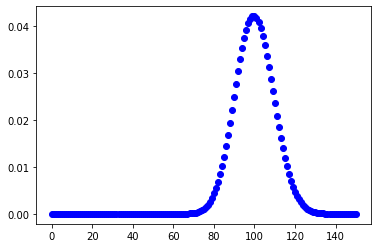

In [67]:
# задаем параметры биномиального распределения
n = 1000
p = 0.1
 
# задаем диапазон значений k для построения графика
max_value = 150
 
binom_probs = []
# для всех значений от 0 до 150
for k in range(max_value + 1):
    # рассчитываем значения вероятности для биномиального распределения
    binom_prob = binom.pmf(k, n, p)
    # добавляем в соответствующие списки
    binom_probs.append(binom_prob)
     
# рисуем графики
plt.plot(range(max_value + 1), binom_probs, 'bo',
         label=f'Биномиальное распределение с n={n} и p={p}');

In [68]:
# задаём параметры подбором n биномиального распределения, чтобы выполнить условие задачи
n = 1170
p = 0.1

# зададим параметры нормального распределения равными
# мат.ожиданию и дисперсии биномиального распределения
mu = n * p
sigma = sqrt(n * p * (1 - p))


# задаём нормальное распределение с математическим ожиданием 18 
# и стандартным отклонением ~3.29
distr = st.norm(mu, sigma) 

# границы интервала
x = 100


# считаем вероятность получить значение от y1:
result = 1- distr.cdf(x)
print(result)


0.9512064034722397


***Ответ:***  минимальное количество промокодов, чтобы вероятность не выполнить план была примерно 5 %. - 1170

##### 
Отдел маркетинга рассылает клиентам push-уведомления в мобильном приложении. Клиенты могут открыть его или не открывать. Известно, что уведомления открывают около 40 % получивших клиентов. Отдел планирует разослать 1 млн уведомлений. С помощью аппроксимации постройте примерный график распределения и оцените вероятность того, что уведомление откроют не более 399,5 тыс. пользователей.

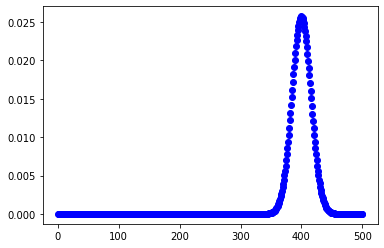

In [69]:
# задаем параметры биномиального распределения
n = 1000
p = 0.4
 
# задаем диапазон значений k для построения графика
max_value = 500
 
binom_probs = []
# для всех значений от 0 до 150
for k in range(max_value + 1):
    # рассчитываем значения вероятности для биномиального распределения
    # и распределения Пуассона
    binom_prob = binom.pmf(k, n, p)
    # добавляем в соответствующие списки
    binom_probs.append(binom_prob)
     
# рисуем графики
plt.plot(range(max_value + 1), binom_probs, 'bo',
         label=f'Биномиальное распределение с n={n} и p={p}');

In [70]:
# задаём параметры биномиального распределения
n = 1000
p = 0.4

# зададим параметры нормального распределения равными
# мат.ожиданию и дисперсии биномиального распределения
mu = n * p
sigma = sqrt(n * p * (1 - p))

distr = st.norm(mu, sigma) 

# граница интервала
x = 399.500


# считаем вероятность получить значение до x:
result = distr.cdf(x)
print(result)

0.48712642829977193


***Ответ:***  вероятность того, что уведомление откроют не более 399,5 тыс. пользователей. - примерно 49 %

#### Общий вывод

Предоставленны 3 наборах данных:
 - с пользователями (df_users - 5 столбцов и 1564 строк)
 - информацией о поездках (df_riders - 4 столбца и 18068 строк)
 - информацией о подписках (df_subs -  4 столбца и 2 строк)  
 
Проведена предобработка данных (согласно приведенному ниже чек-листу):
- привели столбец date к типу даты pandas
- пропусков не было ни в одном из датафреймов. 
- удалили дубликаты из датафрейма с пользователями. 
- добавили столбец с номером месяца.  

Провели исследовательский анализ данных:
 - Частота встречаемости городов: наибольшее кол-во пользователей в Пятигорске - 219, Наименьшее в Москве -168, по-видимому из-за того, что Пятигорск по площади в разы меньше Москвы - в этом городе удобнее пользоваться сервисом для покрытия расстояния. Кол-во пользователей представленных в выборке примерно одинаковое.

 - Соотношение пользователей с подпиской и без подписки: кол-во пользователей без подписки - 835 (~ 54%), пользователей с подпиской - 699 (~46%). Пользователей без подписки больше, но всего процентов на 20, а значит у компании-прокатчика есть неплохая база постоянных клиентов

 - Возраст пользователей: самыми младшими являются пользователи от 12 до 13 лет. Самыми старшими - от 36 до 43 лет. Основная часть пользователей возрастом от 22 до 28 лет. Медиана: 25 лет. Все что меньше 15 лет и больше 40 можно считать редкими значениями.

 - Расстояние, которое пользователь преодолел за одну поездку: cамая короткая дистанция - 0.86 метра, самая длинная - 7.2 км. Короткая дистанция может быть связана с технической неисправностью самоката, его разряженности или же пользователь просто "передумал". В основном пользователи проезжают от 2.5 км примерно до 4 км.

 - Продолжительность поездок: cамая короткая по времени поездка - 0.5 минуты, самая длинная - 41 минута. Так же как и в случае с пройденной дистанцией можно объяснить маленькую продолжительность поезки(тех. неисправность или же пользователь решил отказаться от поезки) В основном пользователи тратят на поездку от 13 до 22 минут.

Объединили данные о пользователях, поездках и тарифах в один датафрейм.

Выделили два датафрейма - sub_free и sub_ultra (датасет для пользователей без подписки и датасет для пользоваетелей с подпиской)

Визуализировали информацию о расстоянии и времени для пользователей с подпиской и без:
- для пользователей без подписки время поездки составляет от 5 до 30 минут, и проезжают от 2 до 5 км, есть пользователи, которые проехали свыше 6 км. Пик кол-ва пользователей приходится на расстояние в 2,5 км
- для пользователей с подпиской. В основном время укладывается в промежуток от 10 до 29 минут. Пик кол-ва пользователей приходится на расстояние в 3 км.  

Так же в обеих группах замечен всплеск в районе 1000 метров и продолжительностью 5-10 мин, скорее всего это "интерес" пользователей к новому сервису аренды. У пользователей без подписки значительно больше коротких поездок - до 1 км и в целом максимальная дальность поездки выше, чем у платных пользователей.


Таким образом, можно сделать вывод, что пользователи без подписки проезжают большее расстояние, чем пользователи на платном тарифе. При этом и те и другие пользователи укладываются в интервал до 30 минут.

Выборка пользователей без подписки почти в два раза превышает выборку пользователей с подпиской (11568 на 6500).

Создали датафрейм с агрегированными данными о поездках на основе датафрейма с объединёнными данными,а так же рассчитали суммарное расстояние, количество поездок и суммарное время для каждого пользователя за каждый месяц.  

В этот же датафрейм добавили столбец с помесячной выручкой, которую принёс каждый пользователь.

Проверили гипотезы:

 - Проверили гипотезу: тратят ли пользователи с подпиской больше времени на поездки?
     - отвергли нулевую гипотезу. Есть основание говорить, что пользователи с подпиской (ultra) тратят больше времени на поездки, чем пользователи без подписки
 - Проверили гипотезу. Можно ли сказать, что расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров?
     - не удалось отвергнуть нулевую гипотезу. Нет оснований утверждать, что пользователи с подпиской проезжают расстояние, не превышающее 3130 метров.
 - Проверили гипотезу о том, будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки.
     - отвергли нулевую гипотезу. Есть основание утверждать, что помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки
 - Какой тест вам понадобился бы для проверки гипотезы о том, что количество обращений в техподдержку значимо снизилось в следствии обновления сервера, с которыми взаимодействует мобильное приложение.
     - Гипотеза о равенстве среднего значения генеральной совокупности до и после изменения для двух зависимых (парных) выборок. Используемый при этой гипотезе метод: `scipy.stats.ttest_rel()`

***Рекомендации по развитию сервиса аренды самокатов:***  
Образ идеального пользователя - пользователь аренды самокатов с подпиской, проезжающего за одну поезку расстояние в районе 3130 метров, живущий в малых городах(по сравнению с Москвой в малых городах пользователей больше) затративающий на поездку от 15 до 20 минут.

На основании того, что пользователи с подпиской тратят больше времени на одну поездку и помесячная выручка больше, чем у пользователей без подписки - мотивировать переход пользователей на подписку ultra. Проводить больше акций, к примеру, раздачи промокодов.   

Для более развернутых рекомендаций нужено провести доп.анализ по стоимости одного километра для пользователей с/без подписки, а так же добавить в выборку время начала и конца поездки для анализа часа пика. Провести анализ по размещению площадок для самокатов так, чтоб пробеги были в районе 3130 метров  и укладывались в 20 минутный интервал - для уменьшения степени износа самокатов (нахождения "золотой середины" между доходом и расходом на обслуживание). Этот анализ даст возможность увеличить кол-во пользователй в больших (в первую очередь) и малых городах.

**Чек-лист готовности проекта**

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Загрузите данных. Считайте CSV-файлы с данными с помощью библиотеки pandas и сохранили их в датафреймы. Пути к файлам:
            - /datasets/users_go.csv
            - /datasets/rides_go.csv
            - /datasets/subscriptions_go.csv
- [x]  Выведите первые строки каждого набора данных. Изучите общую информацию о каждом датафрейме.
- [x]  Предобработка данных
     - Приведите столбец date к типу даты pandas.
     - Создайте новый столбец с номером месяца на основе столбца date.
     - Проверьте наличие пропущенных значений и дубликатов в датафреймах.
- [x]  Исследовательский анализ данных. Опишите и визуализируйте общую информацию о пользователях и поездках:
    - частота встречаемости городов;
    - соотношение пользователей с подпиской и без подписки;
    - возраст пользователей;
    - расстояние, которое пользователь преодолел за одну поездку;
    - продолжительность поездок.
- [x]  Объедините данных
    - Объедините данные о пользователях, поездках и подписках в один датафрейм, методом merge().
    - Создайте ещё два датафрейма из датафрейма: c данными о пользователях без подписки и с данными о пользователях с подпиской.
    - Визуализируйте информацию о расстоянии и времени поездок для пользователей обеих категорий.
- [x]  Подсчёт выручки.
    - Создайте датафрейм с агрегированными данными о поездках на основе датафрейма с объединёнными данными,а так же рассчитали суммарное расстояние, количество поездок и суммарное время для каждого пользователя за каждый месяц.
    - В этот же датафрейм добавили столбец с помесячной выручкой, которую принёс каждый пользователь. 
- [x]  Проверка гипотез
    - Проверьте гипотезу: тратят ли пользователи с подпиской больше времени на поездки?
    - Проверьте гипотезу. Расстояние одной поездки в 3130 метров — оптимальное с точки зрения износа самоката. Можно ли сказать, что расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров?
    - Проверьте гипотезу о том, будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки.
    - Какой тест вам понадобился бы для проверки гипотезы о том, что количество обращений в техподдержку значимо снизилось в следствии обновления сервера, с которыми взаимодействует мобильное приложение.
- [x]  в каждом этапе есть промежуточные выводы
- [x]  есть общий вывод